<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Предобработка-текста" data-toc-modified-id="Предобработка-текста-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Предобработка текста</a></span></li><li><span><a href="#Формирование-выборок" data-toc-modified-id="Формирование-выборок-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Формирование выборок</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

In [1]:
pip install imbalanced-learn==0.9.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Импортируем необходимые библиотеки
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import transformers
import time
from tqdm import notebook
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import os
import warnings

In [3]:
# Читаем данные
toxic_comments = pd.read_csv('/datasets/toxic_comments.csv')

In [4]:
toxic_comments.head(10)

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0
5,5,"""\n\nCongratulations from me as well, use the ...",0
6,6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,7,Your vandalism to the Matt Shirvington article...,0
8,8,Sorry if the word 'nonsense' was offensive to ...,0
9,9,alignment on this subject and which are contra...,0


Данные успешно загружены. Комментарии приведены на английском языке, нам необходим соответсвующий словарь при токенизации и т.д. Колонка "Unnamed: 0" содержит неясную нумерацию, полагаю ее можно будет удалить. В колонке с комментариями "text" выявлены знаки переноса текста "\n" и разный регистр, что нужно будет убрать в процессе предобработки. 

In [5]:
# Проверим наличие дубликатов
toxic_comments.duplicated().sum()

0

Дубликатов не обнаружено.

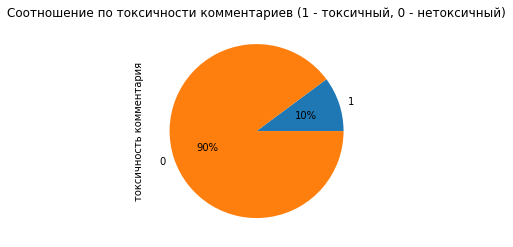

In [6]:
# Выведем круговую диаграмму для токсичности комментария (1 - токсичный, 0 - нетоксичный)
group_tab = toxic_comments.groupby('toxic').size()/len(toxic_comments)
group_tab = group_tab.sort_values(ascending=True)
group_tab.plot(kind='pie', autopct = '%1.0f%%', normalize=False)
plt.title('Соотношение по токсичности комментариев (1 - токсичный, 0 - нетоксичный)')
plt.ylabel('токсичность комментария')
plt.show() 

Токсичность комментария - наш целевой признак. Наблюдается сильный дисбаланс классов в данном признаке который необходимо учитывать далее. 

## Подготовка

### Предобработка текста

In [7]:
# Удалим столбец 'Unnamed: 0'
toxic_comments.drop('Unnamed: 0', axis=1, inplace=True)

In [8]:
# Загружаем корпус стоп-слов (часто встречающихся слов без смысловой нагрузки) для английского языка
nltk.download('stopwords')

# Загружаем теггер частей речи (POS-теггер) на основе усредненного перцептрона
nltk.download('averaged_perceptron_tagger')

# Создаем множество стоп-слов для английского языка
# Используем структуру set для быстрого поиска и удаления стоп-слов из текста
stop_words = set(stopwords.words('english'))

# Инициализируем лемматизатор на основе WordNet
lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Далее создадим функцию для обработки комментариев

In [9]:
# Функция для преобразования POS-тегов в формат, понятный лемматизатору
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # по умолчанию используем существительное

In [10]:
# Функция преобработки комментариев
def pre_processing(text):
    # Очищаем текст: оставляем только английские буквы и пробелы,
    # приводим к нижнему регистру и убираем лишние пробелы
    text = re.sub(r'[^a-z ]', ' ', text.lower()).strip()
    
    # Разбиваем текст на отдельные слова (токенизация)
    tokens = word_tokenize(text)
    
    # Получаем POS-теги для каждого токена
    tokens_with_pos = pos_tag(tokens)
    
    # Фильтруем стоп-слова, сохраняя пары (слово, POS-тег)
    tokens_filtered = [
        (word, pos) for word, pos in tokens_with_pos 
        if word not in stop_words
    ]
    
    # Лемматизируем слова с учетом их POS-тегов
    # и объединяем результат в строку
    text = ' '.join([
        lemmatizer.lemmatize(word, get_wordnet_pos(pos)) 
        for word, pos in tokens_filtered
    ])
    
    return text

In [11]:
# Применим функции к нашим комментариям
toxic_comments['prepro_text'] = toxic_comments['text'].apply(pre_processing)

In [12]:
# Оценим результат применения функции предобработки
toxic_comments.head(10)

,text,toxic,prepro_text
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stick th...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page
5,"""\n\nCongratulations from me as well, use the ...",0,congratulation well use tool well talk
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,cocksucker piss around work
7,Your vandalism to the Matt Shirvington article...,0,vandalism matt shirvington article revert plea...
8,Sorry if the word 'nonsense' was offensive to ...,0,sorry word nonsense offensive anyway intend wr...
9,alignment on this subject and which are contra...,0,alignment subject contrary dulithgow


Комментарии преобразованы корректно. Проанализируем длину преобработанных текстов.

count    159292.000000
mean        235.920040
std         370.557515
min           0.000000
25%          55.000000
50%         120.000000
75%         257.000000
max        5000.000000
Name: len, dtype: float64


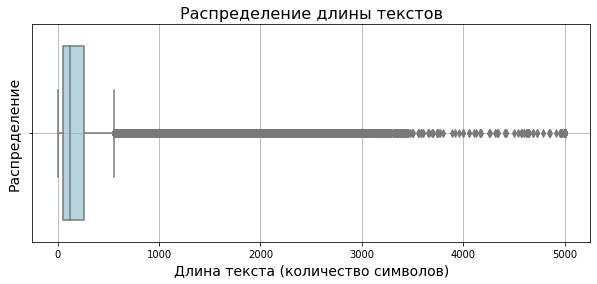

In [13]:
# Создаем колонку с длиной текстов
toxic_comments['len'] = toxic_comments['prepro_text'].str.len()

# Выводим статистическое описание
print(toxic_comments['len'].describe())

# Добавим график
plt.figure(figsize=(10, 4))  # задаем размер графика
sns.boxplot(x=toxic_comments['len'], color='lightblue')
plt.title('Распределение длины текстов', fontsize=16)
plt.xlabel('Длина текста (количество символов)', fontsize=14)
plt.ylabel('Распределение', fontsize=14)
plt.grid(True) 
plt.show()

Мы имеем часть комментариев с нулевой длиной вероятно из-за удаления стоп-слов из которых они полностью состояли. Удалим их. Максимальная длина комментариев 5000 знаков, вероятно этим количеством символов ограничена длина комментария на сайте при его составлении. В основном длина комментариев составляет 50-250 символов.

In [14]:
# Удалим комментарии с нулевой длиной
toxic_comments = toxic_comments.loc[toxic_comments['len'] > 0]
toxic_comments['len'].describe()

count    159230.000000
mean        236.011901
std         370.600402
min           2.000000
25%          55.000000
50%         120.000000
75%         257.000000
max        5000.000000
Name: len, dtype: float64

In [15]:
toxic_comments.head(5)

,text,toxic,prepro_text,len
0,Explanation\nWhy the edits made under my usern...,0,explanation edits make username hardcore metal...,152
1,D'aww! He matches this background colour I'm s...,0,aww match background colour seemingly stick th...,67
2,"Hey man, I'm really not trying to edit war. It...",0,hey man really try edit war guy constantly rem...,132
3,"""\nMore\nI can't make any real suggestions on ...",0,make real suggestion improvement wonder sectio...,352
4,"You, sir, are my hero. Any chance you remember...",0,sir hero chance remember page,29


### Формирование выборок

In [16]:
# Удалим лишние столбцы
toxic_comments.drop(['len', 'text'], axis=1, inplace=True)

In [17]:
toxic_comments.head(5)

,toxic,prepro_text
0,0,explanation edits make username hardcore metal...
1,0,aww match background colour seemingly stick th...
2,0,hey man really try edit war guy constantly rem...
3,0,make real suggestion improvement wonder sectio...
4,0,sir hero chance remember page


In [18]:
# Разделим на входной и целевой признак
X = toxic_comments.drop('toxic', axis=1)
y = toxic_comments['toxic']

In [19]:
# Стратифицированное разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

In [20]:
# Создаем объект для векторизации текста
vectorizer = TfidfVectorizer()
# Применяем его к данным
X_train_tfidf = vectorizer.fit_transform(X_train['prepro_text'])
X_test_tfidf = vectorizer.transform(X_test['prepro_text'])

## Обучение

Обучать будем четыре модели со своими геперпараметрами - 'LogisticRegression', 'LinearSVC', 'DecisionTree' и 'KNeighbors'.

In [21]:
# Инициализация моделей
models = {
    'LogisticRegression': LogisticRegression(max_iter=5000, class_weight='balanced'),
    'LinearSVC': LinearSVC(class_weight='balanced'),
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced'),
    'KNeighbors': KNeighborsClassifier()
}

# Настройка гиперпараметров
param_distributions = {
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l2']
    },
    'LinearSVC': {
        'C': [0.1, 1, 10]
    },
    'DecisionTree': {
        'max_depth': [5, 10, 12],
        'min_samples_split': [2, 5, ]
    },
    'KNeighbors': {
        'n_neighbors': [8, 12, 15]
    }
}

# Словарь для хранения результатов
results = {}

# Цикл обучения с отображением прогресса
for model_name in tqdm(models.keys(), desc="Обучение моделей"):
    model = models[model_name]
    print(f"\nОбучение модели: {model_name}")
    
    start_time = time.time()
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[model_name],
        scoring='f1',
        n_iter=5,  
        cv=5,      
        verbose=0,
        n_jobs=-1,
        random_state=44,
        error_score='raise'
    )
    
    try:
        search.fit(X_train_tfidf, y_train)
    except Exception as e:
        print(f"Ошибка при обучении {model_name}: {e}")
        continue
    
    # Замер времени обучения
    train_time = time.time() - start_time
    
    # Замер времени предсказания
    start_time = time.time()
    y_pred = search.predict(X_train_tfidf)
    predict_time = time.time() - start_time
    
    # Сохраняем best_score_ 
    f1_best = search.best_score_
    
    # Сохранение результатов
    results[model_name] = {
        'best_params': search.best_params_,
        'train_time': train_time,
        'predict_time': predict_time,
        'f1_score': f1_best
    }

# Вывод результатов в таблицу
results_df = pd.DataFrame.from_dict(results, orient='index')
print(results_df)

# Выбор лучшей модели по f1_score
best_model_name = results_df['f1_score'].idxmax()
best_model = models[best_model_name]
print(f"\nBest Model: {best_model}")

Обучение моделей:   0%|          | 0/4 [00:00<?, ?it/s]/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Обучение модели: LogisticRegression


Обучение моделей:  25%|██▌       | 1/4 [05:18<15:54, 318.30s/it]/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Обучение модели: LinearSVC


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
Обучение моделей:  50%|█████     | 2/4 [06:31<05:47, 173.92s/it]


Обучение модели: DecisionTree


Обучение моделей:  75%|███████▌  | 3/4 [13:44<04:52, 292.32s/it]/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 3 is smaller than n_iter=5. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



Обучение модели: KNeighbors


Обучение моделей: 100%|██████████| 4/4 [52:50<00:00, 792.59s/it] 

                                                  best_params   train_time  \
LogisticRegression                 {'penalty': 'l2', 'C': 10}   318.202930   
LinearSVC                                            {'C': 1}    72.846750   
DecisionTree        {'min_samples_split': 5, 'max_depth': 12}   433.085176   
KNeighbors                                {'n_neighbors': 15}  1670.522048   

                    predict_time  f1_score  
LogisticRegression      0.097440  0.763082  
LinearSVC               0.013280  0.760005  
DecisionTree            0.120604  0.592067  
KNeighbors            675.475763  0.662433  

Best Model: LogisticRegression(class_weight='balanced', max_iter=5000)


Лучшая модель с результатом F1_score=0.763 становится LogisticRegression. Незначительно ей уступила модель LinearSVC с F1_score=0.76. Обе модели продемонстрировали по сути одинаковый результат, однако отметим что модель LinearSVC справляется значительно быстрое как в части обучения, так и в части получения предсказаний. 
<br>Таким образом, лучшей моделью для выполнения поставленной задачи является LinearSVC. Поэтому именно модель LinearSVC с соответствующими лучшими гиперпараметрами далее будет проверена на нашей тестовой выборке.

In [22]:
# Проверим модель LinearSVC на тестовых данных

model = LinearSVC(C=1, random_state=42)

model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

f1_score(y_test, y_pred)

0.785897655314051

Модель LinearSVC на тестовых данных продемонстрировала F1_score = 0.786, что удовлетворяет условиям поставленной задачи, F1_score > 0.75. 

## Выводы

В ходе выполнения проекта была успешно решена задача разработки модели машинного обучения для классификации комментариев на позитивные и негативные (токсичные).
<br>
<br>Основные результаты исследования показали, что:
<br>1. Предложенная методология предобработки текстовых данных (очистка, токенизация, удаление стоп-слов, лемматизация) позволила эффективно подготовить данные для анализа
<br>2. Проблема дисбаланса классов была успешно решена с помощью стратифицированной выборки и настройки весов классов
<br>3. Из протестированных моделей наилучшие результаты продемонстрировали модели LogisticRegression и LinearSVC. Ввиду равенства по метрике F1-score и наличия существенной разницы по времени обучения и предсказания, наилучшей моделью для решения поставленной задачи выбрана модель LinearSVC.
<br><br>При проверке качества модели LinearSVC на тестовых данных значение F1-score составило 0.786, что удовлетворяет условиям поставленной задачи, F1_score > 0.75.
<br><br>Рекомендации по внедрению:
<br>Использовать модель LinearSVC как оптимальное решение для поставленной задачи,учитывая время обучения и предсказания при масштабировании системы,
<br>Провести дополнительную валидацию на реальных данных перед промышленным внедрением.</b>
<br><br>Таким образом, цель проекта достигнута: разработана и обучена модель, способная эффективно классифицировать комментарии с требуемым качеством. Результаты исследования могут быть использованы для автоматизации модерации контента и анализа пользовательских отзывов.